# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)

### Density split

In [6]:
nmocks = 1000

In [7]:
nsplits = 2
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_dg_CCFs_cellsize10.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_dg_CCF_cellsize10.npy', allow_pickle=True)

In [8]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)

split = 1
abacus_result = abacus_split_results[split]
s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)
cov = extract_subcovmatrix(s, split_cov, ells, nsplits, split_extract=split)

### 2PCF

In [9]:
nsplits = 1
abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF.npy')
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF.npy', allow_pickle=True)

_, cov = get_poles(mocks_results, ells)

s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)

[000002.30]  06-01 17:22  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF.npy.


In [10]:
cov /= 8.

In [11]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
cov *= hartlap

## Set power spectrum model

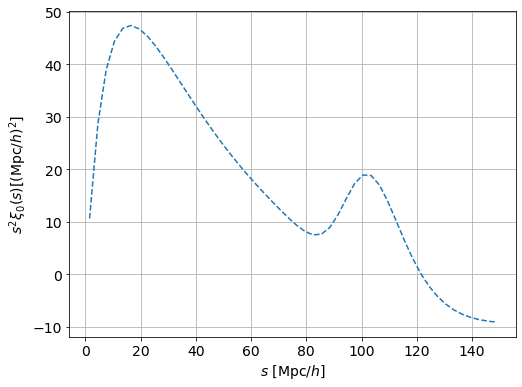

In [12]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0, 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 8, 'sigma_perp': 3, 'sigma_s': 0}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [13]:
# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2., 'alpha_par': 1., 'sigma_par': 8., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, negative=False)

Optimal parameters:
{'b': 1.7834796126449808, 'alpha_par': 1.0005238468116582, 'sigma_par': 3.564400410138889, 'broadband_coeffs': array([ 1.87993465e+00, -2.99473789e-02,  1.33812661e-04])}

Covariance matrix:
[[ 4.45382383e-03  2.70376307e-05  3.33220082e-02 -2.17388158e-01
   2.68069081e-03 -7.18170982e-06]
 [ 2.70376307e-05  1.05906776e-05  3.34367053e-04 -5.60490169e-04
   1.63870520e-05 -7.22375474e-08]
 [ 3.33220082e-02  3.34367053e-04  4.57257773e-01 -1.59854886e+00
   1.94054167e-02 -4.87466020e-05]
 [-2.17388158e-01 -5.60490169e-04 -1.59854886e+00  2.10534265e+01
  -3.93173437e-01  1.70576184e-03]
 [ 2.68069081e-03  1.63870520e-05  1.94054167e-02 -3.93173437e-01
   8.74809500e-03 -4.26940249e-05]
 [-7.18170982e-06 -7.22375474e-08 -4.87466020e-05  1.70576184e-03
  -4.26940249e-05  2.28020559e-07]]

Sigmas:
[6.67369750e-02 3.25433213e-03 6.76208380e-01 4.58840130e+00
 9.35312515e-02 4.77514983e-04]


({'b': 1.7834796126449808,
  'alpha_par': 1.0005238468116582,
  'sigma_par': 3.564400410138889,
  'broadband_coeffs': array([ 1.87993465e+00, -2.99473789e-02,  1.33812661e-04])},
 array([[ 4.45382383e-03,  2.70376307e-05,  3.33220082e-02,
         -2.17388158e-01,  2.68069081e-03, -7.18170982e-06],
        [ 2.70376307e-05,  1.05906776e-05,  3.34367053e-04,
         -5.60490169e-04,  1.63870520e-05, -7.22375474e-08],
        [ 3.33220082e-02,  3.34367053e-04,  4.57257773e-01,
         -1.59854886e+00,  1.94054167e-02, -4.87466020e-05],
        [-2.17388158e-01, -5.60490169e-04, -1.59854886e+00,
          2.10534265e+01, -3.93173437e-01,  1.70576184e-03],
        [ 2.68069081e-03,  1.63870520e-05,  1.94054167e-02,
         -3.93173437e-01,  8.74809500e-03, -4.26940249e-05],
        [-7.18170982e-06, -7.22375474e-08, -4.87466020e-05,
          1.70576184e-03, -4.26940249e-05,  2.28020559e-07]]))

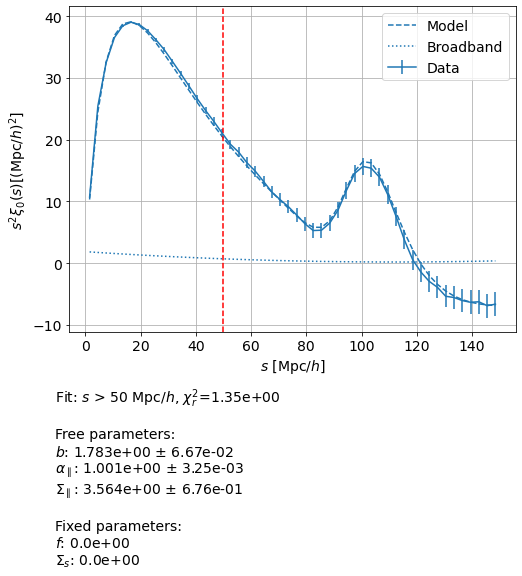

In [14]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)
#plt.title('DS1 (randoms-halos)')
plt.show()

### Plot reduced $\chi^2$ as a function of a given parameter ($\alpha_{iso}$ or $\Sigma_{iso}$)

In [15]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

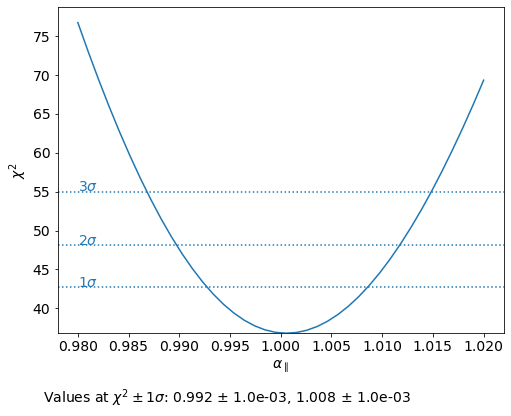

In [16]:
alphas = np.linspace(0.98, 1.02, 40)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


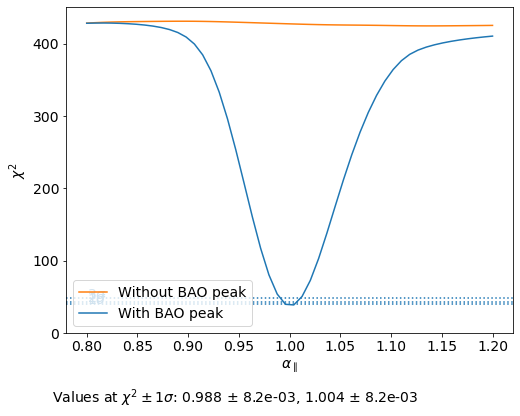

In [14]:
alphas = np.linspace(0.8, 1.2, 50)

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)

In [15]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

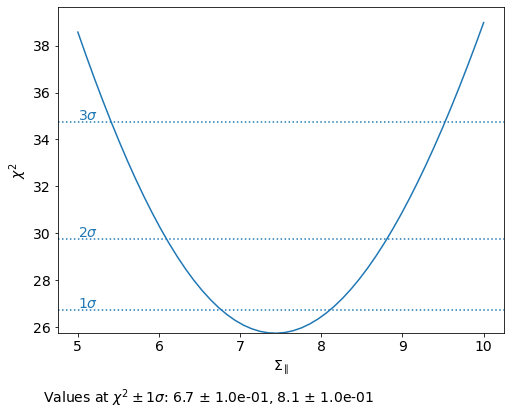

In [17]:
sigmas = np.linspace(5, 10, 50)
free_params_init = {'b': 2., 'alpha_par': 1., 'broadband_coeffs': broadband_coeffs}

sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [ ]:
sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)